In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms, datasets, models
import os
import cv2
from tqdm import tqdm
from PIL import Image


In [3]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [4]:
#Inititate constants
PREPROCESS_DATA = 1 #Change to 1 when training
TRAINING_DATA = 1 #Change to 1 if want model to be trained again
BATCH_SIZE = 64
IMG_SIZE = 224
TRAINING_SAMPLES = 20000
VAL_SAMPLES = 4944

In [5]:
LABEL = {"cats":0, "dogs": 1}

In [6]:
DATA_DIR = 'data/trainingSet' 
TEST_DIR = 'data/testSet/test'

In [7]:
#Normalize images
data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [8]:
#Load data into Dataloader, split into Training set and Validation set
if PREPROCESS_DATA:
    dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms)  
    train_datasets ,val_datasets = torch.utils.data.random_split(dataset, [TRAINING_SAMPLES, VAL_SAMPLES])  
    trainloader = data.DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
    valloader = data.DataLoader(val_datasets, batch_size=BATCH_SIZE, num_workers=4)

In [9]:
#Show size of data
print(len(dataset))

24944


In [10]:
#Show labels in dataset
print(dataset.classes)

['cats', 'dogs']


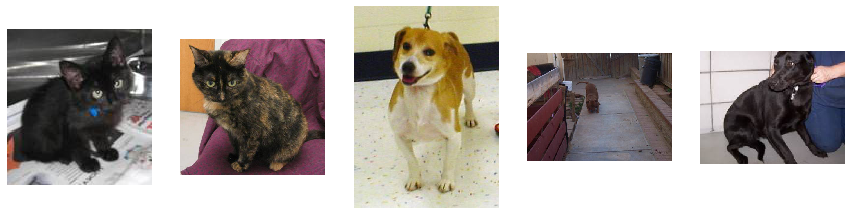

In [11]:
#Visualize training data
test_path = os.listdir(TEST_DIR)
a = np.random.randint(1000)
NUM_PIC=5

fig = plt.figure(figsize=(15,15))
for id, i in enumerate(test_path[a:a+NUM_PIC]):
    img = Image.open(os.path.join(TEST_DIR,i))
    fig.add_subplot(1,NUM_PIC,id+1)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [12]:
#Forward Propagation for both training and validation
def forwardprop(model, error, optimizer, trainloader, valloader=None, training = False):
    correct = 0
    total = 0
    total_loss = 0
    if training:
        model.train()
    else:
        model.eval()
    for (train, labels) in trainloader:
        train = train.to(device)
        labels = labels.to(device)
        if training:
            optimizer.zero_grad()
        outputs = model(train)
        predicted = torch.max(outputs.data, 1)[1]
        loss = error(outputs, labels)
        if training:
            loss.backward()
            optimizer.step()
        else:
            correct += (predicted==labels).sum()
        total += len(labels)
        total_loss += loss.data
    if training:
        with torch.no_grad():
            val_acc, val_loss = forwardprop(model = model, error = error, optimizer = optimizer, trainloader = valloader)
    else:
        accuracy = correct*1.0/total

    if training:    
        return total_loss, val_acc, val_loss
    else:
        return accuracy, total_loss

In [13]:
#Plot loss curve
def plot(train_loss_list, val_loss_list, val_acc_list, EPOCH):
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCH),train_loss_list)
    plt.plot(range(EPOCH),val_loss_list)
    plt.title("Loss per epoch")
    fig.add_subplot(1,2,2)
    plt.plot(range(EPOCH),val_acc_list)
    plt.title("Validation Accuracy")
    plt.show()

In [14]:
#Training process
def train(model, error, optimizer, trainloader, valloader):
    EPOCHS = 5
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    print("Start training process....")
    for epoch in range(EPOCHS):
        train_loss, val_acc, val_loss = forwardprop(model,error,optimizer,trainloader,valloader,True)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        print("Epoch: ({}/{}) | Training Loss: {:.2f} | Validation Loss: {:.2f} | Validation Accuracy: {:.2f}".format(epoch+1,EPOCHS,train_loss,val_loss,val_acc))
    #Save model
    torch.save(model.state_dict(), "model/model1.pth")
    print("Training Completed! Model has been saved")
    #Plot loss
    print("Ploting loss...")
    plot(train_loss_list,val_loss_list,val_acc_list,EPOCHS)
    return model

Train model and Plot the learning curve

Start training process....
Epoch: (1/5) | Training Loss: 124.32 | Validation Loss: 17.19 | Validation Accuracy: 0.95
Epoch: (2/5) | Training Loss: 59.12 | Validation Loss: 11.33 | Validation Accuracy: 0.96
Epoch: (3/5) | Training Loss: 45.62 | Validation Loss: 8.98 | Validation Accuracy: 0.97
Epoch: (4/5) | Training Loss: 39.62 | Validation Loss: 8.03 | Validation Accuracy: 0.97
Epoch: (5/5) | Training Loss: 35.64 | Validation Loss: 7.33 | Validation Accuracy: 0.97
Training Completed! Model has been saved
Ploting loss...


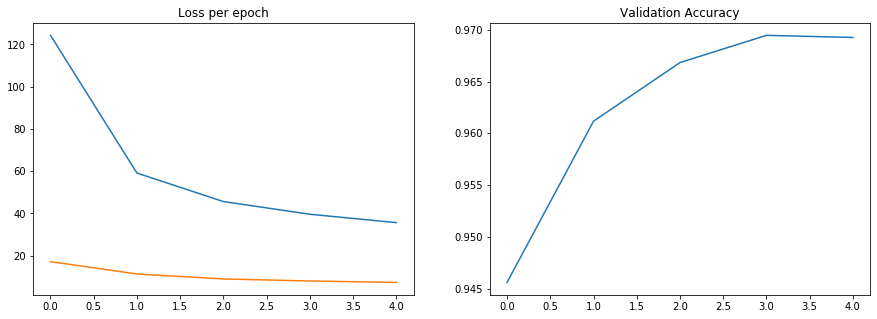

In [15]:
#Training Inititate
if TRAINING_DATA:
    
    #Load model ResNet18
    model = models.resnet18(pretrained=True)
    model = model.to(device)
    #Freeze all convolution layer
    for param in model.parameters():
            param.requires_grad = False

    #Unfreeze Fully-connected layer, edit the last layer 
    model.fc = nn.Linear(in_features=512, out_features=2).to(device)
    error = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    model = train(model,error,optimizer,trainloader,valloader)
else:
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model = model.to(device)
    model.load_state_dict(torch.load("model/model5.pth"))

In [16]:
#Predict input images
def predict(model, images):
    model.eval()
    with torch.no_grad():
        test = Variable(images).view(-1,3,IMG_SIZE,IMG_SIZE)
        test = test.to(device)
        outputs = model(test)
        prediction = outputs.data
        prediction = torch.max(outputs.data, 1)[1]
    return prediction.cpu().numpy()[0]

In [17]:
#Predict and visualize some test images
def visualize_model(model,TEST_DIR, NUM_PIC = 10):
    test_path = os.listdir(TEST_DIR)
    a = np.random.randint(1000)
    fig = plt.figure(figsize=(15,8))
    for id, i in enumerate(test_path[a:a+NUM_PIC]):
        img = Image.open(os.path.join(TEST_DIR,i))
        img2 = data_transforms(img)
        result = predict(model,img2)
        fig.add_subplot(2,NUM_PIC/2,id+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("CAT" if result==0 else "DOG")
    plt.show()

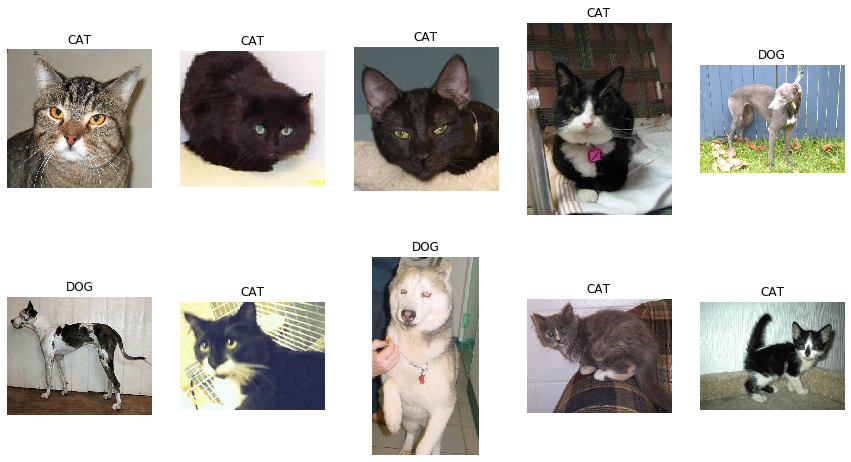

In [18]:
#Visualize
visualize_model(model,TEST_DIR)